In [4]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import matplotlib
from tifffile import imread
from sklearn.model_selection import train_test_split
import xgboost as xgb
import os
from scipy import interpolate
from scipy.signal import medfilt
from scipy.signal import find_peaks
import csv
import pandas as pd
import cv2

matplotlib.rcParams['figure.figsize'] = [10, 10]

In [5]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def normalize_image(image, dest_dtype=np.uint16):
    dtype_mapping = {
        np.uint16: cv2.CV_16U,
        np.uint8: cv2.CV_8U,
        np.float32: cv2.CV_32F,
        np.float64: cv2.CV_64F
    }

    if dest_dtype not in dtype_mapping:
        raise ValueError("dest_dtype must be one of np.uint16, np.uint8, np.float32, np.float64")

    dest_dtype_cv2 = dtype_mapping[dest_dtype]
    max_value = np.iinfo(dest_dtype).max if dest_dtype in [np.uint16, np.uint8] else 1

    return cv2.normalize(image, None, 0, max_value, cv2.NORM_MINMAX, dtype=dest_dtype_cv2) # type: ignore

In [6]:
labels = "/mnt/towbin.data/personal/spsalmon/pharyngeal_pumping/orientation_training_database/labels/labels.csv"
database_dir = "/mnt/towbin.data/personal/spsalmon/pharyngeal_pumping/orientation_training_database/"
classes= ["facing_left", "facing_right", "error"]
classes = np.array(classes)
labels = pd.read_csv(labels)

train_labels, test_labels = train_test_split(labels, test_size=0.2, random_state=42)

In [7]:
def extract_features(img_path, features_size):
    img = imread(img_path)
    img = normalize_image(img)
    std = np.std(img, axis =0)

    feature = np.zeros((features_size))
    feature[0:std.shape[0]] = std
    return feature

def get_features_and_labels(dataframe, features_size, classes):
    features = np.empty((0, features_size))
    labels = np.empty((0, len(classes)))

    for e in dataframe:

        img_path = os.path.join(database_dir, e[0])
        label = (classes == e[1]).astype(int)
        feature = extract_features(img_path, features_size)

        features = np.append(features, np.array([feature]), axis=0)
        labels = np.append(labels, np.array([label]), axis=0)
        
    return features, labels

train_features, train_labels = get_features_and_labels(train_labels.values, 5000, classes)
test_features, test_labels = get_features_and_labels(test_labels.values, 5000, classes)

In [8]:
dtrain = xgb.DMatrix(train_features, label=train_labels)
dtest = xgb.DMatrix(test_features, label=test_labels)

evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [9]:
param = {'max_depth': 9, 'eta': 0.03, 'objective': "multi:softmax", 'num_class':3}
param['nthread'] = 32
# param['eval_metric'] = 'rmse'

clf = xgb.XGBClassifier(max_depth=7, n_estimators=1000)

clf.fit(train_features, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [10]:
pred_on_test = clf.predict(test_features)
errors = abs(pred_on_test - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.02 degrees.


In [11]:
clf.save_model("./model.json")

In [12]:
clf_test = xgb.XGBClassifier()
clf_test.load_model("./model.json")

e = clf_test.predict_proba(test_features)

In [13]:
num_round = 1000
bst = xgb.train(param, dtrain, num_round, evals = evallist, verbose_eval=4, early_stopping_rounds=20)
# bst = xgb.train(param, dtrain, num_round)

XGBoostError: [14:12:13] ../include/xgboost/objective.h:98: multioutput is not supported by current objective function
Stack trace:
  [bt] (0) /home/spsalmon/env_directory/pharynx/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x2d1853) [0x7f910578a853]
  [bt] (1) /home/spsalmon/env_directory/pharynx/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x2df66c) [0x7f910579866c]
  [bt] (2) /home/spsalmon/env_directory/pharynx/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x2df8cd) [0x7f91057988cd]
  [bt] (3) /home/spsalmon/env_directory/pharynx/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x2ec087) [0x7f91057a5087]
  [bt] (4) /home/spsalmon/env_directory/pharynx/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterBoostedRounds+0x31) [0x7f91055f50d1]
  [bt] (5) /usr/lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7f9286c38ff5]
  [bt] (6) /usr/lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7f9286c3840a]
  [bt] (7) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x5b6) [0x7f9286e39306]
  [bt] (8) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x139dc) [0x7f9286e399dc]



In [ ]:
dtest = xgb.DMatrix(test_features)
ypred = bst.predict(dtest)

# bst.save_model("./model.txt")

In [ ]:
predictions = ypred
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.01 degrees.


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

print("max error :", np.max(mape, axis = 0), "Index :", np.argmax(mape, axis = 0))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# 98.72, 9

max error : [inf inf inf] Index : [1 0 0]
Accuracy: -inf %.


/tmp/ipykernel_1017937/1444179886.py:2: RuntimeWarning: divide by zero encountered in true_divide
  mape = 100 * (errors / test_labels)


128
210
278
359
[128. 210. 278. 359.]
[127. 225. 295. 368.]
[  1. -15. -17.  -9.]


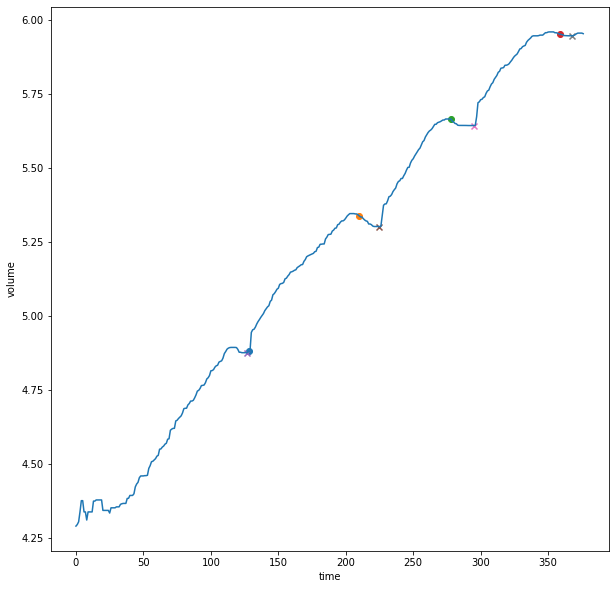

In [ ]:
ypred = np.round(ypred)
p = 500

# def smooth(y, box_pts):
#     box = np.ones(box_pts)/box_pts
#     y_smooth = np.convolve(y, box, mode='same')
#     return y_smooth

# yhat = smooth(test_features[p, :], 8)
# smooth = savitzky_golay(test_features[p, :], 11, 3)
# filt = medfilt(test_features[p, :], 5)
# plt.plot(filt)
# plt.plot(yhat)

growth_curve = test_features[p, 0:700]
growth_curve = growth_curve[growth_curve > 0]
plt.plot(growth_curve)
plt.xlabel("time")
plt.ylabel("volume")
# plt.plot(smooth)

for e in predictions[p, :]:
    e= round(e)
    print(e)
    plt.scatter(e, test_features[p, e])
for e in test_labels[p, :]:
    e = int(e)
    plt.scatter(e, test_features[p, e], marker = 'x')

print(ypred[p, :])
print(np.round(test_labels[p, :]))
print(ypred[p, :] - np.round(test_labels[p, :]))